In [2]:
import time

import numpy as np
from matplotlib import pyplot as plt
import complex_road
import importlib
importlib.reload(complex_road)

<module 'complex_road' from '/mnt/c/Users/EJ/Documents/College/ACME/v4_project_winter/complex_road.py'>

[[ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0. ]
 [ 1.   0.   0.  -0.1  0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.1  0.  -0.6  0. ]
 [ 0.   0.   1.   0.   0.   0.6  0. ]]
start...
took  1.5279132200003005


<Figure size 3276.8x2457.6 with 0 Axes>

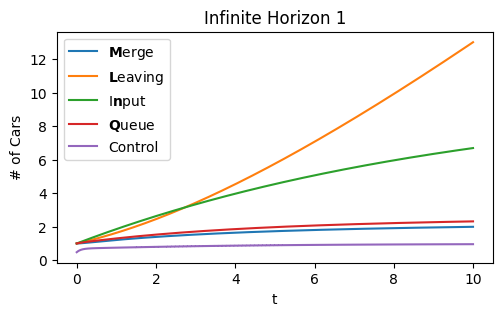

In [5]:
m = complex_road.ComplexRoad(
    "nml",
    np.array([0.1, 0.3]),
    np.array([2.0]),
    np.array([1.]),
    1.
)

print(m._get_evolution(np.array([1.]))[0])

time_start = time.perf_counter()
print("start...")
roads, queues, control = m.multi_step(
    np.array([1., 1., 1.]),
    np.array([1.]),
    (0., 10.),
    num_intervals=1000
)
print("took ", time.perf_counter() - time_start)

# Extract into the form Brigg had
t_space = np.linspace(0, 10., 1001000)
n, m, l, = roads
q, = queues
u, = control

plt.gcf().set_dpi(512)
plt.figure(figsize=(3.75 * 1.5, 3))
plt.plot(t_space, m, label=f"$\\bf{{M}}$erge")
plt.plot(t_space, l, label=f"$\\bf{{L}}$eaving")
plt.plot(t_space, n, label=f"I$\\bf{{n}}$put")
plt.plot(t_space, q, label=f"$\\bf{{Q}}$ueue")
plt.plot(t_space, u, label=f"Control")
plt.title("Infinite Horizon 1")
plt.xlabel("t")
plt.ylabel("# of Cars")
plt.legend()
#plt.savefig(f"LQR_figures/infinite_multi.pdf", transparent=False)